In [34]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
# Parameters

##### release position 
release_zone = "test_001"
bathymodiolus_delta_lat = 0.08  #change??

release_depth = 20

# release particles
number_particles = 100

# release timing
release_time_in_days = 1   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 1
start_day = 1

# experiment duration etc
runtime_in_days = 5
dt_in_minutes = 60

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "../data/config/test_stations.csv"

# location of input data
data_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS119' 
data_resolution = '1d'

# location of mask data
mask_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
mesh_mask_filename = '1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc'

# names of files to load
fname_U = f'1_{experiment_name}_{data_resolution}_20??*_grid_U_iMirabilis.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_20??*_grid_V_iMirabilis.nc'
fname_T = f'1_{experiment_name}_{data_resolution}_20??*_grid_T_iMirabilis.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_20??*_grid_W_iMirabilis.nc'

# location of output data
outpath = f'../output_data/{experiment_name}'
output_filename = '{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [3]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [4]:
data_path = Path(data_path)
mask_path = Path(mask_path)
outpath = Path(outpath)
mesh_mask = mask_path / experiment_name / mesh_mask_filename
output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename

In [5]:
ds_mesh_mask = xr.open_dataset(mesh_mask)
display(ds_mesh_mask)

<xarray.Dataset>
Dimensions:       (t: 1, y: 409, x: 362, z: 46)
Dimensions without coordinates: t, y, x, z
Data variables: (12/44)
    e1f           (t, y, x) float64 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e2f           (t, y, x) float64 ...
    e2t           (t, y, x) float64 ...
    ...            ...
    tmask         (t, z, y, x) int8 ...
    tmaskutil     (t, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    umaskutil     (t, y, x) int8 ...
    vmask         (t, z, y, x) int8 ...
    vmaskutil     (t, y, x) int8 ...
Attributes:
    file_name:                  1_mesh_mask.nc
    TimeStamp:                  01/11/2021 17:36:58 +0100
    history:                    Tue Nov 23 18:14:30 2021: ncks -F -d x,1390,1...
    history_of_appended_files:  Mon Nov 22 14:05:28 2021: Appended file 1_mes...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

### Load release location

In [6]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=";")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [7]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

In [8]:
def fieldset_defintions(
    list_of_filenames_U, list_of_filenames_V,
    list_of_filenames_W, list_of_filenames_T,
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                 'T': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_T[0],
                       'data': list_of_filenames_T}
                }

    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                 'T': 'votemper'
                }
                 
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                       'time': 'time_counter'},  # needs to be on f-nodes
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht',
                        'time': 'time_counter'},  # needs to be on t-nodes
                 }  

    return FieldSet.from_nemo(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

In [9]:
def create_fieldset(
    data_path=data_path, experiment_name=experiment_name,
    fname_U=fname_U, fname_V=fname_V, fname_W=fname_W, fname_T=fname_T,
    mesh_mask = mesh_mask
):
    
    files_U = list(sorted((data_path / experiment_name).glob(fname_U)))
    files_V = list(sorted((data_path / experiment_name).glob(fname_V)))
    files_W = list(sorted((data_path / experiment_name).glob(fname_W)))
    files_T = list(sorted((data_path / experiment_name).glob(fname_T)))
    
    fieldset = fieldset_defintions(
        files_U, files_V,
        files_W, files_T, mesh_mask)
    return fieldset

In [10]:
fieldset = create_fieldset()

### Create a set of particles with random initial positions

In [11]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

######
lat = np.random.normal(
    loc=bathymodiolus_lat, scale=bathymodiolus_delta_lat,
    size=time.shape
)

lon = np.random.normal(
    loc=bathymodiolus_lon, scale=bathymodiolus_delta_lon,
    size=time.shape
)

depth = np.ones(time.size) * release_depth 

speed_param = np.random.uniform(
    low=0, high=1.0, size=time.shape
)

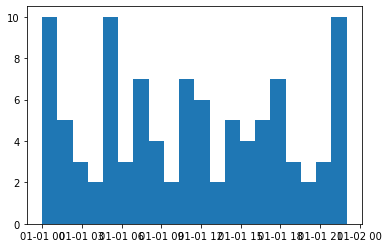

In [12]:
plt.hist(time, bins=20);

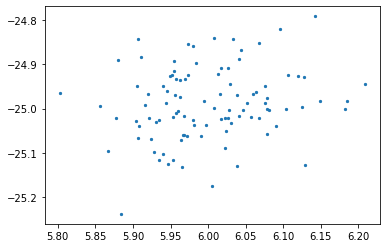

In [13]:
plt.scatter(lon, lat, s=5);

In [14]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle, #SampleParticle later? muss dann vorher auch def werden,
    lat=lat,
    lon=lon,
    depth=depth,
    time=time
)

CPU times: user 3.54 ms, sys: 1.69 ms, total: 5.23 ms
Wall time: 1.72 ms


In [15]:
kernel = pset.Kernel(AdvectionRK4_3D)

### Be able to handle errors during integration

In [16]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {
        ErrorCode.ErrorOutOfBounds: DeleteParticle
    }

In [17]:
outfile

PosixPath('../output_data/INALT20.L46-KFS119/test_001_20090101_RT-5_N-100_seed-12345.nc')

In [18]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [19]:
pset.execute(
    kernel,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-726810/lib18848481c57e87de3733bdf17402a9f8_0.so


In [20]:
output_pfile.export()

In [28]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 7)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

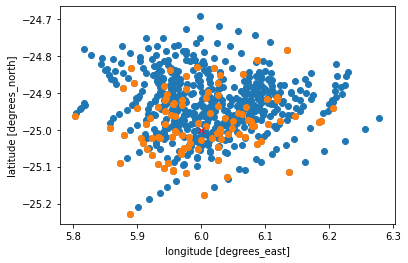

In [22]:
#ocean_ds.isel(time=0, depth=1).uo.isnull().plot(x="lon", y="lat")
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

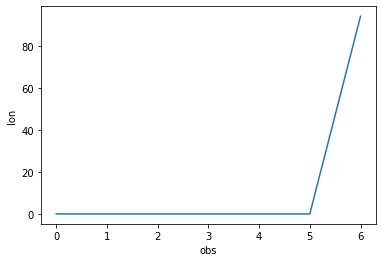

In [23]:
particle_ds.lon.isnull().sum("traj").plot()